In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pyproj import Transformer

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial import Voronoi
import json
import numpy as np

import geopy
from geopy import distance

from copy import deepcopy

### PHARMACY part | create voronoi polygon for each amenity

In [3]:
# data IN
amen = pd.read_csv("data/total-amenity-locations.csv", index_col=0)
pharma = amen[amen['type']=='pharmacy'].reset_index(drop=True)

In [4]:
# CRS types
crs_eov = 'epsg:23700'
crs_map = 'epsg:4326'

In [5]:
# creating lon/lat coordinates from eov coordinates

#transformer
transform_map_to_eov = Transformer.from_crs(crs_map, crs_eov)

# transformation
pharma["eov_x"], pharma["eov_y"] = transform_map_to_eov.transform(
    pharma["lat"].tolist(),
    pharma["lon"].tolist()
)

In [6]:
# creating geometry column
pharma["geometry_eov"] = pharma.apply(lambda row: Point(row["eov_x"],row["eov_y"]), axis=1)
pharma = gpd.GeoDataFrame(pharma, geometry="geometry_eov")
pharma.head()

,lon,lat,type,eov_x,eov_y,geometry_eov
0,17.748459,46.884122,pharmacy,550999.963887,171921.053948,POINT (550999.964 171921.054)
1,19.028022,47.644617,pharmacy,648540.917144,255641.233082,POINT (648540.917 255641.233)
2,19.038559,47.430091,pharmacy,649329.580464,231790.815616,POINT (649329.580 231790.816)
3,17.462633,45.959543,pharmacy,527133.835213,69566.303034,POINT (527133.835 69566.303)
4,17.471084,45.960618,pharmacy,527791.311495,69672.533530,POINT (527791.311 69672.534)


In [7]:
# ccodinate values for Voronoi function
coords_eov = pharma[["eov_x","eov_y"]].values

In [8]:
# calculating Voronoi cells from Cartesian point coordinates
vor = Voronoi(coords_eov)

In [9]:
# function to get voronoi polygon index for each coord pair
def voronoi_polygon(index):
    """
    This function returns a Voronoi polygon around the Point given by index.
    If the polygon is not closed (point is on the edge), it returns None.
    """
    if index%1000==0:
        print(index,end=", ")
    if -1 not in set(vor.regions[vor.point_region[index]]):
        xy = vor.vertices[vor.regions[vor.point_region[index]],]
        x = list(xy[:,0])
        y = list(xy[:,1])

        return Polygon(list(zip(x,y)))

In [10]:
# apply the function to get voronoi for each coord pair
pharma["voronoi_cell_eov"] = pharma.index.map(voronoi_polygon)
pharma.dropna(subset=["voronoi_cell_eov"],inplace=True)

## NOTE - some amenities DO NOT GET a polygon

# reset index
pharma.reset_index(drop=True)
pharma.head()

0, 1000, 

,lon,lat,type,eov_x,eov_y,geometry_eov,voronoi_cell_eov
0,17.748459,46.884122,pharmacy,550999.963887,171921.053948,POINT (550999.964 171921.054),"POLYGON ((556280.2038231025 170742.5265913544,..."
1,19.028022,47.644617,pharmacy,648540.917144,255641.233082,POINT (648540.917 255641.233),"POLYGON ((650314.2190168536 255297.0616619329,..."
2,19.038559,47.430091,pharmacy,649329.580464,231790.815616,POINT (649329.580 231790.816),"POLYGON ((648647.1697309685 231623.7677638179,..."
4,17.471084,45.960618,pharmacy,527791.311495,69672.533530,POINT (527791.311 69672.534),"POLYGON ((527781.1040439295 76373.24691416598,..."
5,19.047991,47.510537,pharmacy,650041.193160,240734.292196,POINT (650041.193 240734.292),"POLYGON ((650288.0456410943 240747.1851928855,..."


### PIXEL data

In [11]:
# read Budapest pixel geometry
bp_pixels = gpd.read_file('data/bp_pixel_pop_corrected.shp')

In [12]:
# centroid of pixels
bp_pixels['centroid'] = bp_pixels.apply(lambda row: row['geometry'].centroid, axis=1)

In [13]:
# get lon / lat of centroid
bp_pixels['cent_lon'] = bp_pixels.centroid.apply(lambda p: p.x)
bp_pixels['cent_lat'] = bp_pixels.centroid.apply(lambda p: p.y)

/tmp/ipykernel_7827/4254125439.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bp_pixels['cent_lon'] = bp_pixels.centroid.apply(lambda p: p.x)
/tmp/ipykernel_7827/4254125439.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bp_pixels['cent_lat'] = bp_pixels.centroid.apply(lambda p: p.y)


In [14]:
#transformer
transform_map_to_eov = Transformer.from_crs(crs_map, crs_eov)

# transformation
bp_pixels["eov_cent_x"],bp_pixels["eov_cent_y"] = transform_map_to_eov.transform(
    bp_pixels["cent_lat"].tolist(),
    bp_pixels["cent_lon"].tolist()
)

In [15]:
# creating centroid eov point column
bp_pixels["centroid_eov"] = bp_pixels.apply(lambda row: Point(row["eov_cent_x"],row["eov_cent_y"]), axis=1)

In [16]:
# change key geometry of the gpd
bp_pixels = bp_pixels.set_geometry("centroid_eov")

In [17]:
# create spatial index based on key geometry
spatial_index = bp_pixels.sindex

### spatial JOINS

In [18]:
# change key geometry of the gpd
pharma = pharma.set_geometry("voronoi_cell_eov")

# spatial join to join polygons and point
pharma2 = gpd.sjoin(pharma, bp_pixels, op="contains")

/tmp/ipykernel_7827/3291543025.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  pharma2 = gpd.sjoin(pharma, bp_pixels, op="contains")


### distance

In [20]:
# distance - parhmacy POINT pixel centroid
pharma2['distance'] = pharma2.apply(
    lambda r: distance.distance(
                (r["lat"],r["lon"]),
                (r["cent_lat"],r["cent_lon"])).km, axis=1)

### THE PLOT

In [22]:
def reproject_polygon_back(p):
    """
    Custom fast projection function for polygons.
    """
    lon,lat = np.array(p.boundary.coords).T
    x,y = transform_map_to_eov.transform(lat,lon)
    return Polygon(list(zip(x,y)))

In [23]:
# reproject pixel geometry to eov
pharma2["geometry_eov"] = pharma2["geometry"].map(reproject_polygon_back)

# set geometry_eov as the geometry of gpd
pharma2.set_geometry("geometry_eov",inplace=True)

In [26]:
# shapes for roads, rivers and Budapest lines

bp_shape = gpd.read_file('data/bp_df_proj.shp')
bp_roads = gpd.read_file('data/bp_roads_proj.shp')
bp_waters = gpd.read_file('data/bp_waters_proj.shp')

In [27]:
def reproject_polygon_back(p):
    """
    Custom fast projection function for polygons.
    """
    lon,lat = np.array(p.boundary.coords).T
    x,y = transform_map_to_eov.transform(lat,lon)
    return Polygon(list(zip(x,y)))

In [28]:
# reproject pixel geometry to eov
pharma2["geometry_eov"] = pharma2["geometry"].map(reproject_polygon_back)

# set geometry_eov as the geometry of gpd
pharma2.set_geometry("geometry_eov",inplace=True)

#### ENG version

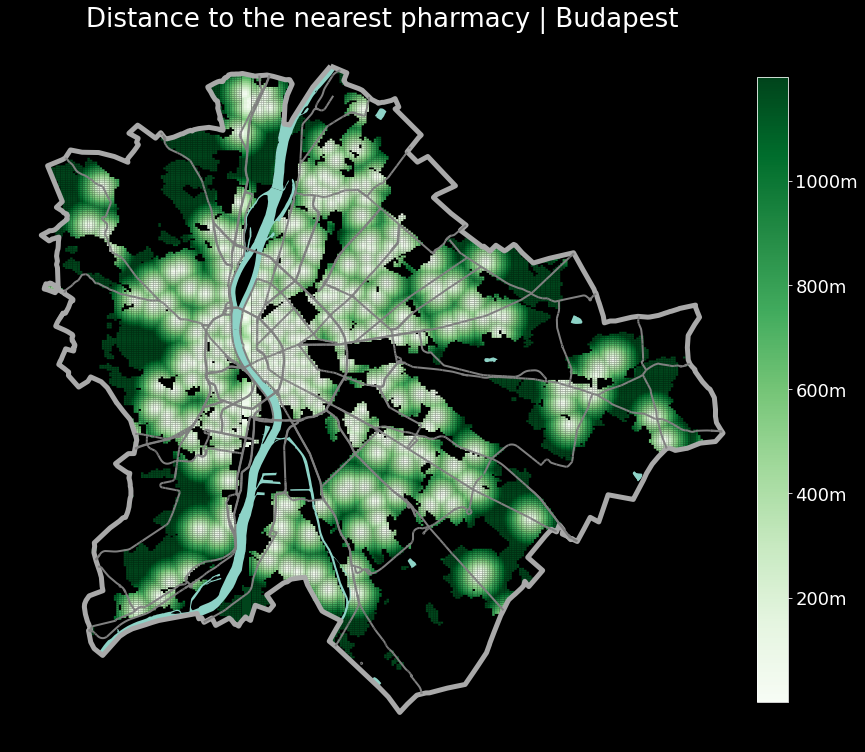

In [32]:
## PHARMACY PLOT

from matplotlib.colors import LogNorm,PowerNorm

plt.style.use('dark_background')
vmin = 0
vmax = 1.2
fig, ax = plt.subplots(1, figsize=(14,14))

mp = pharma2.plot(column="distance", cmap="Greens", ax=ax, vmin=vmin, vmax=vmax)


bp_shape.boundary.plot(ax=ax,lw=5,color="darkgrey")
bp_roads.plot(ax=ax,lw=2,color="grey")
bp_waters.plot(ax=ax)

# create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
#cbar = fig.colorbar(sm)
cbar = fig.colorbar(sm, ticks=[0.2, 0.4, 0.6, 0.8, 1], fraction=0.04, pad=0.0001)

cbar.ax.set_yticklabels(['200m', '400m', '600m', '800m', '1000m'], size=18)


ax.axis("off")
plt.title("Distance to the nearest pharmacy | Budapest", size=26)
plt.savefig("dist_pharmacy.png", dpi=600, bbox_inches='tight')
plt.show()